In [1]:
import tensorflow as tf; print(tf.__version__)

2.0.0


In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

#### GPU Hickups

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
# physical_devices = tf.config.experimental.list_physical_device  

tf.config.experimental.set_memory_growth(physical_devices[0], True) 
assert tf.config.experimental.get_memory_growth(physical_devices[0]) 


In [4]:
tf.test.is_built_with_cuda()
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

True

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7417433128456525617
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6967288727507582727
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 18243514364204148420
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10813302375
locality {
  bus_id: 3
  numa_node: 2
  links {
  }
}
incarnation: 15170722574184283275
physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:43:00.0, compute capability: 7.5"
]


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

### Detection CNN

In [9]:
class FireDetectionNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1
        
        model.add(SeparableConv2D(16, (7, 7), padding="same",
                                  input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        model.add(SeparableConv2D(32, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        model.add(SeparableConv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(SeparableConv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        model.add(Flatten())
        model.add(Dense(128))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # second set of FC => RELU layers
        model.add(Dense(128))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model

In [10]:
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import tempfile

In [11]:
class LearningRateFinder:
    def __init__(self, model, stopFactor=4, beta=0.98):
        # store the model, stop factor, and beta value (for computing
        # a smoothed, average loss)
        self.model = model
        self.stopFactor = stopFactor
        self.beta = beta

        # initialize our list of learning rates and losses,
        # respectively
        self.lrs = []
        self.losses = []

        # initialize our learning rate multiplier, average loss, best
        # loss found thus far, current batch number, and weights file
        self.lrMult = 1
        self.avgLoss = 0
        self.bestLoss = 1e9
        self.batchNum = 0
        self.weightsFile = None

    def reset(self):
        # re-initialize all variables from our constructor
        self.lrs = []
        self.losses = []
        self.lrMult = 1
        self.avgLoss = 0
        self.bestLoss = 1e9
        self.batchNum = 0
        self.weightsFile = None

    def is_data_iter(self, data):
        # define the set of class types we will check for
        iterClasses = ["NumpyArrayIterator", "DirectoryIterator",
             "DataFrameIterator", "Iterator", "Sequence"]

        # return whether our data is an iterator
        return data.__class__.__name__ in iterClasses

    def on_batch_end(self, batch, logs):
        # grab the current learning rate and add log it to the list of
        # learning rates that we've tried
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # grab the loss at the end of this batch, increment the total
        # number of batches processed, compute the average average
        # loss, smooth it, and update the losses list with the
        # smoothed value
        l = logs["loss"]
        self.batchNum += 1
        self.avgLoss = (self.beta * self.avgLoss) + ((1 - self.beta) * l)
        smooth = self.avgLoss / (1 - (self.beta ** self.batchNum))
        self.losses.append(smooth)

        # compute the maximum loss stopping factor value
        stopLoss = self.stopFactor * self.bestLoss

        # check to see whether the loss has grown too large
        if self.batchNum > 1 and smooth > stopLoss:
            # stop returning and return from the method
            self.model.stop_training = True
            return

        # check to see if the best loss should be updated
        if self.batchNum == 1 or smooth < self.bestLoss:
            self.bestLoss = smooth

        # increase the learning rate
        lr *= self.lrMult
        K.set_value(self.model.optimizer.lr, lr)

    def find(self, trainData, startLR, endLR, epochs=None,
        stepsPerEpoch=None, batchSize=32, sampleSize=2048,
        classWeight=None, verbose=1):
        # reset our class-specific variables
        self.reset()

        # determine if we are using a data generator or not
        useGen = self.is_data_iter(trainData)

        # if we're using a generator and the steps per epoch is not
        # supplied, raise an error
        if useGen and stepsPerEpoch is None:
            msg = "Using generator without supplying stepsPerEpoch"
            raise Exception(msg)

        # if we're not using a generator then our entire dataset must
        # already be in memory
        elif not useGen:
            # grab the number of samples in the training data and
            # then derive the number of steps per epoch
            numSamples = len(trainData[0])
            stepsPerEpoch = np.ceil(numSamples / float(batchSize))

        # if no number of training epochs are supplied, compute the
        # training epochs based on a default sample size
        if epochs is None:
            epochs = int(np.ceil(sampleSize / float(stepsPerEpoch)))

        # compute the total number of batch updates that will take
        # place while we are attempting to find a good starting
        # learning rate
        numBatchUpdates = epochs * stepsPerEpoch

        # derive the learning rate multiplier based on the ending
        # learning rate, starting learning rate, and total number of
        # batch updates
        self.lrMult = (endLR / startLR) ** (1.0 / numBatchUpdates)

        # create a temporary file path for the model weights and
        # then save the weights (so we can reset the weights when we
        # are done)
        self.weightsFile = tempfile.mkstemp()[1]
        self.model.save_weights(self.weightsFile)

        # grab the *original* learning rate (so we can reset it
        # later), and then set the *starting* learning rate
        origLR = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, startLR)

        # construct a callback that will be called at the end of each
        # batch, enabling us to increase our learning rate as training
        # progresses
        callback = LambdaCallback(on_batch_end=lambda batch, logs:
            self.on_batch_end(batch, logs))

        # check to see if we are using a data iterator
        if useGen:
            self.model.fit_generator(
                trainData,
                steps_per_epoch=stepsPerEpoch,
                epochs=epochs,
                class_weight=classWeight,
                verbose=verbose,
                callbacks=[callback])

        # otherwise, our entire training data is already in memory
        else:
            # train our model using Keras' fit method
            self.model.fit(
                trainData[0], trainData[1],
                batch_size=batchSize,
                epochs=epochs,
                class_weight=classWeight,
                callbacks=[callback],
                verbose=verbose)

        # restore the original model weights and learning rate
        self.model.load_weights(self.weightsFile)
        K.set_value(self.model.optimizer.lr, origLR)

    def plot_loss(self, skipBegin=10, skipEnd=1, title=""):
        # grab the learning rate and losses values to plot
        lrs = self.lrs[skipBegin:-skipEnd]
        losses = self.losses[skipBegin:-skipEnd]

        # plot the learning rate vs. loss
        plt.plot(lrs, losses)
        plt.xscale("log")
        plt.xlabel("Learning Rate (Log Scale)")
        plt.ylabel("Loss")
        
        # if the title is not empty, add it to the plot
        if title != "":
            plt.title(title)

In [12]:
import os
from datetime import date

today = date.today()

#directory to output all the figures and model
baseDir = "/userdata/kerasData/output"
targetDir = os.path.sep.join([baseDir,str(today)])
if not os.path.exists(baseDir):
    os.mkdir(baseDir)
    print('Created directory: ' + baseDir)

if not os.path.exists(targetDir):
    os.mkdir(targetDir)
    print('Created directory: ' + targetDir)

# set the path to the serialized model after training
MODEL_PATH = os.path.sep.join([targetDir, "fire_detection.model"])
# define the path to the output learning rate finder plot and
# training history plot
LRFIND_PLOT_PATH = os.path.sep.join([targetDir, "lrfindd_plot.png"])
TRAINING_PLOT_PATH = os.path.sep.join([targetDir, "training_plot.png"])

# define the path to the output directory that will store our final
# output with labels/annotations along with the number of iamges to
# sample
OUTPUT_IMAGE_PATH = os.path.sep.join([targetDir, "examples"])
SAMPLE_SIZE = 50

### Loading Data

In [13]:
import matplotlib
matplotlib.use("Agg")
 
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import sys
import regex as re

In [14]:
def load_dataset(datasetPath):
    # grab the paths to all images in our dataset directory, then
    # initialize our lists of images
    imagePaths = os.listdir(datasetPath)
    trainXList = []
    testXList = []
    testX = np.array([])
    trainY = np.array([])
    trainY = np.array([])
    testY = np.array([])

    testI = 0 
    
    # loop over the image paths
    for directories in imagePaths:
        tempF= []
        tempNF = []
        
        for element in os.listdir(datasetPath + "/"+ directories):
            if re.search(".jpg", element):
                image = cv2.imread(datasetPath + "/"+ directories + "/" + element)
                image = cv2.resize(image, (128,128))
            if "+" in element:
                tempF.append(image)
            else:
                tempNF.append(image)
                
        tempF = np.array(tempF, dtype="float32")
        tempNF = np.array(tempNF,  dtype="float32")
        
        fireLabels = np.ones((tempF.shape[0],))
        nonFireLabels = np.zeros((tempNF.shape[0],))
        data = np.vstack([tempF, tempNF])
        labels = np.hstack([fireLabels, nonFireLabels])
        labels = to_categorical(labels, num_classes=2)
        
        #print(labels)
        
        data /= 255

        (t_trainX, t_testX, t_trainY, t_testY) = train_test_split(data, labels,
                                                                  test_size=0.2, random_state=42)
        
        trainXList.append(t_trainX)
        testXList.append(t_testX)
        
        if trainY.size == 0:
            trainY = t_trainY
            testY = t_testY
        else:
            trainY = np.append(trainY, t_trainY, axis = 0)
            testY = np.append(testY, t_testY, axis = 0)

    
    trainX = np.vstack(trainXList)
    testX = np.vstack(testXList)
    
    labels = np.append(trainY, testY)
    labels = to_categorical(labels, num_classes=2)
    classTotals = labels.sum(axis=0)
    classWeight = classTotals.max() / classTotals
    
    print(trainX.shape, testX.shape, trainY.shape, testY.shape)
        
    return trainX, testX, trainY, testY, classWeight

#### Load a smaller dataset for debugging purposes
I copied one folder from `/userdata/kerasData/wildfireP/hpwren.ucsd.edu/HWBHPWREN-FIgLib`

```bash
/userdata/kerasData/wildfireP/hpwren.ucsd.edu/HWB
mkdir HPWREN-SmallTest
cp HPWREN-FIgLib/20170625-BBM-bm-n-mobo/ HPWREN-SmallTest/
```

In [15]:
# fireDataDir = "/userdata/kerasData/wildfireP/hpwren.ucsd.edu/HWB/HPWREN-SmallTest"
# trainX, testX, trainY, testY, classWeight = load_dataset(fireDataDir)

#### Load the entire dataset

In [16]:
fireDataDir = "/userdata/kerasData/labeldata"
#Does it exist, if not download from object storage
if not os.path.exists(fireDataDir):
    #make a call to api to download data
    print('Created directory: ' + targetDir)
trainX, testX, trainY, testY, classWeight = load_dataset(fireDataDir)

(2618, 128, 128, 3) (686, 128, 128, 3) (2618, 2) (686, 2)


Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['re']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


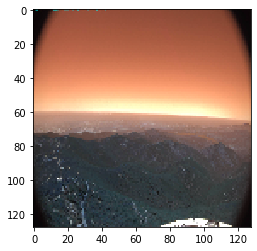

In [17]:
%pylab inline
plt.imshow(trainX[0,:,:,:])
plt.show()

## Start of Model

In [18]:
BATCH_SIZE = 8
Width = 128
Height = 128
Depth = 3
Classes= 2
# initialize the class labels in the dataset
CLASSES = ["Non-Fire", "Fire"]

# define the size of the training and testing split
TRAIN_SPLIT = 0.75
TEST_SPLIT = 0.25

# define the initial learning rate, batch size, and number of epochs
INIT_LR = 1e-3
BATCH_SIZE = 8
NUM_EPOCHS = 50

In [19]:
model = FireDetectionNet.build(width=Width, height=Height, depth=Depth, classes=Classes)

In [20]:
opt= SGD(lr=INIT_LR, momentum=0.9,decay=INIT_LR / NUM_EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics = ['accuracy'])

aug = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

#### Learning Rate Finder

In [21]:
lrf = LearningRateFinder(model)
stepsPerEpochNum=np.ceil((trainX.shape[0] / float(BATCH_SIZE)))

In [22]:
lrf.find(
    aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
    1e-10, 1e+1,
    stepsPerEpoch=stepsPerEpochNum,
    epochs=50,
    batchSize=BATCH_SIZE,
    classWeight=classWeight)


Epoch 1/50
328/328 [==============================] - 27s 82ms/step - loss: 1.2116 - accuracy: 0.5275
Epoch 2/50
328/328 [==============================] - 25s 77ms/step - loss: 1.2871 - accuracy: 0.5275
Epoch 3/50
328/328 [==============================] - 27s 82ms/step - loss: 1.3071 - accuracy: 0.5095
Epoch 4/50
328/328 [==============================] - 27s 81ms/step - loss: 1.3111 - accuracy: 0.5080
Epoch 5/50
328/328 [==============================] - 26s 80ms/step - loss: 1.3382 - accuracy: 0.5031
Epoch 6/50
328/328 [==============================] - 26s 80ms/step - loss: 1.3406 - accuracy: 0.4912
Epoch 7/50
328/328 [==============================] - 27s 81ms/step - loss: 1.2723 - accuracy: 0.5176
Epoch 8/50
328/328 [==============================] - 26s 79ms/step - loss: 1.2844 - accuracy: 0.5076
Epoch 9/50
328/328 [==============================] - 26s 81ms/step - loss: 1.3382 - accuracy: 0.4969
Epoch 10/50
328/328 [==============================] - 26s 78ms/step - loss: 1.321

Loss Rate finder complete


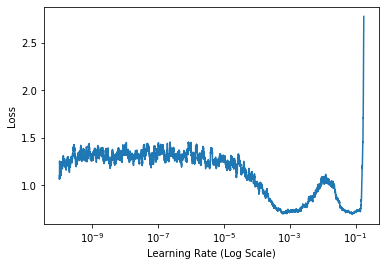

In [23]:
lrf.plot_loss()
plt.savefig(LRFIND_PLOT_PATH)
print("Loss Rate finder complete")

In [24]:
# define the initial learning rate, batch size, and number of epochs
INIT_LR = 1e-3
BATCH_SIZE = 8
NUM_EPOCHS = 50

### Start of Training

In [25]:
aug = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [26]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
modelCheckpointFile = os.path.sep.join([targetDir, 'best_model.h5'])
mc = tf.keras.callbacks.ModelCheckpoint(modelCheckpointFile, monitor='val_loss', mode='min', verbose=1)

In [27]:
H = model.fit_generator(
    aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
    validation_data=(testX, testY),
    steps_per_epoch=trainX.shape[0] // BATCH_SIZE,
    epochs=NUM_EPOCHS,
    class_weight=classWeight,
    callbacks=[mc],
    verbose=1)

Epoch 1/50
326/327 [============================>.] - ETA: 0s - loss: 2.6110 - accuracy: 0.5008
Epoch 00001: saving model to /userdata/kerasData/output/2020-05-26/best_model.h5
327/327 [==============================] - 29s 89ms/step - loss: 2.6073 - accuracy: 0.5008 - val_loss: 0.8618 - val_accuracy: 0.5816
Epoch 2/50
326/327 [============================>.] - ETA: 0s - loss: 1.1525 - accuracy: 0.5138
Epoch 00002: saving model to /userdata/kerasData/output/2020-05-26/best_model.h5
327/327 [==============================] - 31s 95ms/step - loss: 1.1524 - accuracy: 0.5134 - val_loss: 0.6777 - val_accuracy: 0.6458
Epoch 3/50
326/327 [============================>.] - ETA: 0s - loss: 0.8211 - accuracy: 0.4962
Epoch 00003: saving model to /userdata/kerasData/output/2020-05-26/best_model.h5
327/327 [==============================] - 29s 88ms/step - loss: 0.8203 - accuracy: 0.4969 - val_loss: 0.6844 - val_accuracy: 0.5306
Epoch 4/50
326/327 [============================>.] - ETA: 0s - loss: 

Epoch 28/50
326/327 [============================>.] - ETA: 0s - loss: 0.7130 - accuracy: 0.5177
Epoch 00028: saving model to /userdata/kerasData/output/2020-05-26/best_model.h5
327/327 [==============================] - 36s 111ms/step - loss: 0.7131 - accuracy: 0.5176 - val_loss: 0.7234 - val_accuracy: 0.4155
Epoch 29/50
326/327 [============================>.] - ETA: 0s - loss: 0.7161 - accuracy: 0.5108
Epoch 00029: saving model to /userdata/kerasData/output/2020-05-26/best_model.h5
327/327 [==============================] - 34s 104ms/step - loss: 0.7162 - accuracy: 0.5111 - val_loss: 0.7193 - val_accuracy: 0.4082
Epoch 30/50
326/327 [============================>.] - ETA: 0s - loss: 0.7097 - accuracy: 0.5391
Epoch 00030: saving model to /userdata/kerasData/output/2020-05-26/best_model.h5
327/327 [==============================] - 35s 107ms/step - loss: 0.7095 - accuracy: 0.5398 - val_loss: 0.7208 - val_accuracy: 0.4213
Epoch 31/50
326/327 [============================>.] - ETA: 0s -

In [28]:
# H = model.fit(x=trainX,y=trainY, batch_size=BATCH_SIZE,
#     validation_data=(testX, testY),
#     steps_per_epoch=trainX.shape[0] // BATCH_SIZE,
#     epochs=NUM_EPOCHS,
#     class_weight=classWeight,
#     callbacks=[mc],
#     verbose=2)

[INFO] evaluating network...
              precision    recall  f1-score   support

    Non-Fire       0.36      0.91      0.52       238
        Fire       0.76      0.15      0.25       448

    accuracy                           0.41       686
   macro avg       0.56      0.53      0.38       686
weighted avg       0.62      0.41      0.34       686

[INFO] serializing network to '/userdata/kerasData/output/2020-05-26/fire_detection.model'...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /userdata/kerasData/output/2020-05-26/fire_detection.model/assets


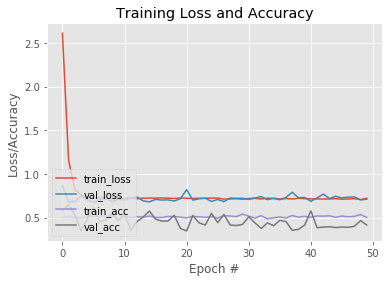

In [29]:
# evaluate the network and show a classification report
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BATCH_SIZE)
print(classification_report(testY.argmax(axis=1),
    predictions.argmax(axis=1), target_names=CLASSES))
 
# serialize the model to disk
print("[INFO] serializing network to '{}'...".format(MODEL_PATH))
model.save(MODEL_PATH)
 
# construct a plot that plots and saves the training history
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(TRAINING_PLOT_PATH)

In [30]:
model.load_weights(modelCheckpointFile)

In [31]:
loss,acc = model.evaluate(testX,testY)

686/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [32]:
print("Test Accuracy: " + str(acc))

Test Accuracy: 0.41399416


### Transfer to TF.LITE

In [33]:
from tensorflow import lite

In [34]:
converter = lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [35]:
tfLiteModelFile = os.path.sep.join([targetDir, 'model.tflite'])
open(tfLiteModelFile, "wb").write(tflite_model)

8501404

### Upload tf model to object storage

In [38]:
#Check for object storage enviroment variables
import subprocess

SAGE_HOST = os.getenv('SAGE_HOST')
SAGE_USER_TOKEN = os.getenv('SAGE_USER_TOKEN')
BUCKET_ID_MODEL = os.getenv('BUCKET_ID_MODEL')

if SAGE_HOST is None:
    raise EnvironmentError("Failed because {} is not set.".format('SAGE_HOST'))
    
if SAGE_USER_TOKEN is None:
    raise EnvironmentError("Failed because {} is not set.".format('SAGE_USER_TOKEN'))
    
if BUCKET_ID_MODEL is None:
    raise EnvironmentError("Failed because {} is not set.".format('BUCKET_ID_MODEL'))
    
command = 'sage-cli.py storage files upload ' +  str(BUCKET_ID_MODEL) + ' ' + str(tfLiteModelFile)
print(command)
result = subprocess.run(command, check=True, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
print(result)

sage-cli.py storage files upload 710699fe-ef1f-4f4a-8307-1502489f02d2 --key output /userdata/kerasData/output/2020-05-26
CompletedProcess(args='sage-cli.py storage files upload 710699fe-ef1f-4f4a-8307-1502489f02d2 --key output /userdata/kerasData/output/2020-05-26', returncode=0, stdout=b'localFile: /userdata/kerasData/output/2020-05-26/training_plot.png\nkey: output sourceDirName: 2020-05-26  root_suffix:  file: training_plot.png\nremoteKey: output/2020-05-26/training_plot.png\nhttps://sage-storage-api.nautilus.optiputer.net/api/v1/objects/710699fe-ef1f-4f4a-8307-1502489f02d2/output/2020-05-26/training_plot.png\nlocalFile: /userdata/kerasData/output/2020-05-26/best_model.h5\nkey: output sourceDirName: 2020-05-26  root_suffix:  file: best_model.h5\nremoteKey: output/2020-05-26/best_model.h5\nhttps://sage-storage-api.nautilus.optiputer.net/api/v1/objects/710699fe-ef1f-4f4a-8307-1502489f02d2/output/2020-05-26/best_model.h5\nlocalFile: /userdata/kerasData/output/2020-05-26/model.tflite\nk